# Classification challenge

During next hours we will compete to build a classifier of natural scenes using a [dataset provided by NCTU](https://www.kaggle.com/c/cs-ioc5008-hw1/overview) (National Chiao Tung University, Taiwan).

[Leaderboard](https://www.kaggle.com/c/cs-ioc5008-hw1/leaderboard)

# Don't forget to configure the execution environment to run in GPU

## Download images from Google Drive

In [12]:
# Import Google Drive libraries
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [13]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
# Authenticate with your Google Account
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [15]:
# Download the dataset of the challenge
download = drive.CreateFile({'id': '1DeEJ_LtbgIYPLYcPu3bD818iKXH_w8ru'})
download.GetContentFile('challenge.zip')

In [16]:
# Extract the files
import zipfile
from pathlib import Path
data_path = Path("./challenge.zip")

with zipfile.ZipFile(str(data_path), 'r') as zip_ref:
    zip_ref.extractall("./data")

In [17]:
ls

challenge.zip  data/  sample_data/


In [18]:
ls data

test/  train/


In [19]:
ls data/train

bedroom/  forest/   insidecity/  livingroom/  office/       street/  tallbuilding/
coast/    highway/  kitchen/     mountain/    opencountry/  suburb/


In [20]:
ls data/train/bedroom

image_0000.jpg  image_0023.jpg  image_0046.jpg  image_0069.jpg  image_0092.jpg  image_0115.jpg
image_0001.jpg  image_0024.jpg  image_0047.jpg  image_0070.jpg  image_0093.jpg  image_0116.jpg
image_0002.jpg  image_0025.jpg  image_0048.jpg  image_0071.jpg  image_0094.jpg  image_0117.jpg
image_0003.jpg  image_0026.jpg  image_0049.jpg  image_0072.jpg  image_0095.jpg  image_0118.jpg
image_0004.jpg  image_0027.jpg  image_0050.jpg  image_0073.jpg  image_0096.jpg  image_0119.jpg
image_0005.jpg  image_0028.jpg  image_0051.jpg  image_0074.jpg  image_0097.jpg  image_0120.jpg
image_0006.jpg  image_0029.jpg  image_0052.jpg  image_0075.jpg  image_0098.jpg  image_0121.jpg
image_0007.jpg  image_0030.jpg  image_0053.jpg  image_0076.jpg  image_0099.jpg  image_0122.jpg
image_0008.jpg  image_0031.jpg  image_0054.jpg  image_0077.jpg  image_0100.jpg  image_0123.jpg
image_0009.jpg  image_0032.jpg  image_0055.jpg  image_0078.jpg  image_0101.jpg  image_0124.jpg
image_0010.jpg  image_0033.jpg  image_0056.jpg  im

In [21]:
ls data/test

image_0000.jpg  image_0174.jpg  image_0348.jpg  image_0522.jpg  image_0696.jpg  image_0870.jpg
image_0001.jpg  image_0175.jpg  image_0349.jpg  image_0523.jpg  image_0697.jpg  image_0871.jpg
image_0002.jpg  image_0176.jpg  image_0350.jpg  image_0524.jpg  image_0698.jpg  image_0872.jpg
image_0003.jpg  image_0177.jpg  image_0351.jpg  image_0525.jpg  image_0699.jpg  image_0873.jpg
image_0004.jpg  image_0178.jpg  image_0352.jpg  image_0526.jpg  image_0700.jpg  image_0874.jpg
image_0005.jpg  image_0179.jpg  image_0353.jpg  image_0527.jpg  image_0701.jpg  image_0875.jpg
image_0006.jpg  image_0180.jpg  image_0354.jpg  image_0528.jpg  image_0702.jpg  image_0876.jpg
image_0007.jpg  image_0181.jpg  image_0355.jpg  image_0529.jpg  image_0703.jpg  image_0877.jpg
image_0008.jpg  image_0182.jpg  image_0356.jpg  image_0530.jpg  image_0704.jpg  image_0878.jpg
image_0009.jpg  image_0183.jpg  image_0357.jpg  image_0531.jpg  image_0705.jpg  image_0879.jpg
image_0010.jpg  image_0184.jpg  image_0358.jpg  im

# Let's hack some code!

# Explore the data

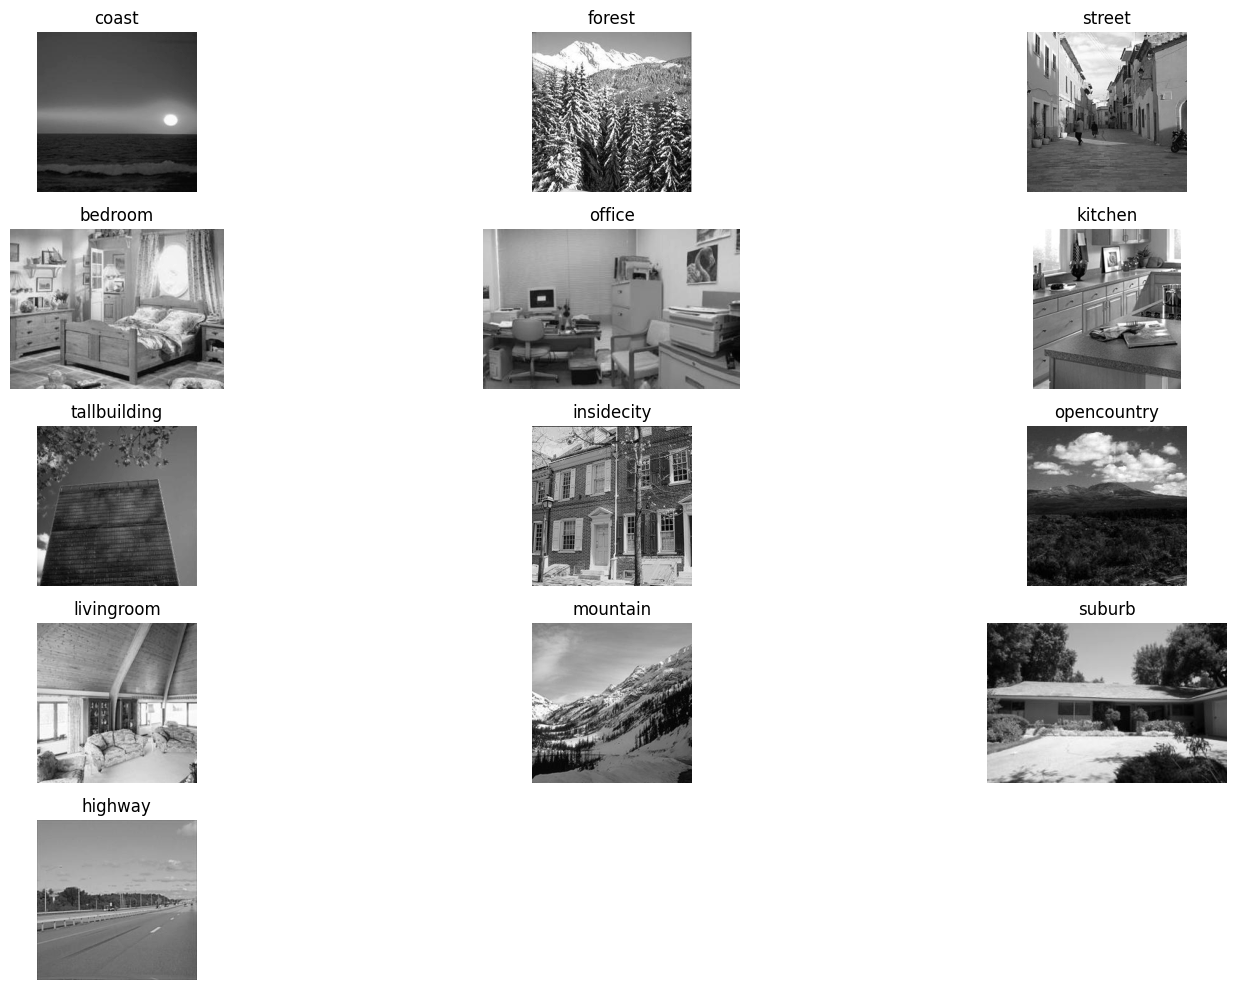

In [28]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Directorio donde se encuentran las imágenes de entrenamiento
train_dir = "./data/train"

# Lista de clases
classes = os.listdir(train_dir)

# Configurar la visualización de las imágenes
total_classes = len(classes)
columns = 3
rows = (total_classes + columns - 1) // columns

# Crear una nueva figura
plt.figure(figsize=(15, 10))

# Iterar sobre cada clase y mostrar una imagen por clase
for i, class_name in enumerate(classes):
    class_dir = os.path.join(train_dir, class_name)
    image_files = os.listdir(class_dir)

    # Tomar la primera imagen de cada clase
    image_path = os.path.join(class_dir, image_files[0])
    image = Image.open(image_path)

    plt.subplot(rows, columns, i + 1)

    # Si la imagen está en color, configurar el mapa de colores en None
    if image.mode == 'RGB':
        plt.imshow(image)
    # Si la imagen está en escala de grises, configurar el mapa de colores en gray
    else:
        plt.imshow(image, cmap='gray')

    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()


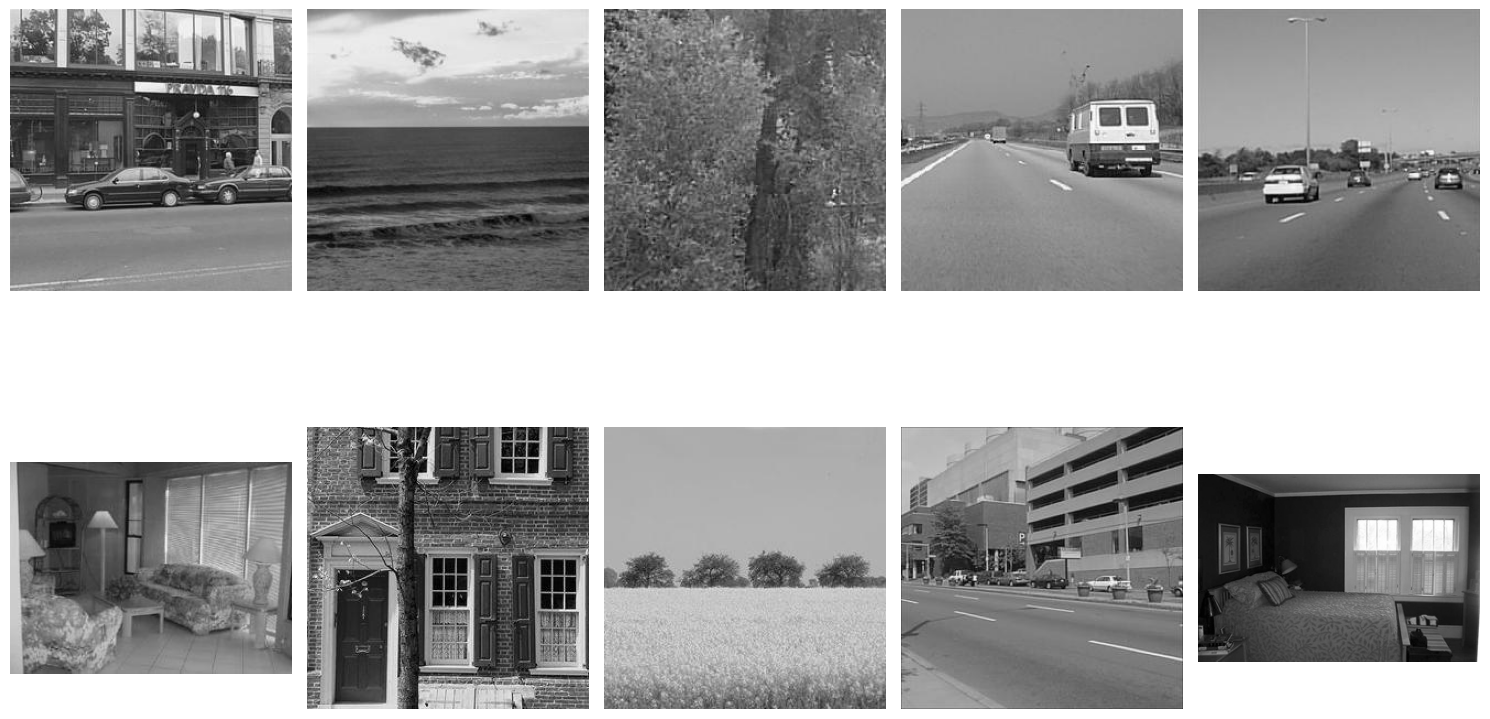

In [31]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Directorio donde se encuentran las imágenes de prueba
test_dir = "./data/test"

# Obtener una lista de archivos de imagen en el directorio de prueba
image_files = os.listdir(test_dir)

# Configurar la visualización de las imágenes
plt.figure(figsize=(15, 10))

# Iterar sobre las primeras 10 imágenes y mostrarlas
for i in range(10):
    image_path = os.path.join(test_dir, image_files[i])
    image = Image.open(image_path).convert('RGB')  # Convertir a modo RGB

    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')

plt.tight_layout()
plt.show()


# Experiment

In [35]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Directorios de datos
train_dir = "./data/train"
test_dir = "./data/test"

# Parámetros de preprocesamiento de imágenes
target_size = (150, 150)
batch_size = 32

# Preprocesamiento de datos de entrenamiento
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical')

# Definición del modelo CNN básico
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

# Compilación del modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    verbose=1
)


Found 2819 images belonging to 13 classes.
Epoch 1/10
88/88 [==============================] - 9s 43ms/step - loss: 2.2270 - accuracy: 0.2422
Epoch 2/10
88/88 [==============================] - 4s 46ms/step - loss: 1.4510 - accuracy: 0.4905
Epoch 3/10
88/88 [==============================] - 5s 56ms/step - loss: 1.1624 - accuracy: 0.6121
Epoch 4/10
88/88 [==============================] - 4s 43ms/step - loss: 0.9805 - accuracy: 0.6738
Epoch 5/10
88/88 [==============================] - 4s 42ms/step - loss: 0.7036 - accuracy: 0.7467
Epoch 6/10
88/88 [==============================] - 4s 50ms/step - loss: 0.5438 - accuracy: 0.8134
Epoch 7/10
88/88 [==============================] - 4s 43ms/step - loss: 0.4075 - accuracy: 0.8536
Epoch 8/10
88/88 [==============================] - 4s 44ms/step - loss: 0.2933 - accuracy: 0.9003
Epoch 9/10
88/88 [==============================] - 5s 55ms/step - loss: 0.1423 - accuracy: 0.9523
Epoch 10/10
88/88 [==============================] - 4s 43ms/step 

1/1 [==============================] - 0s 22ms/step


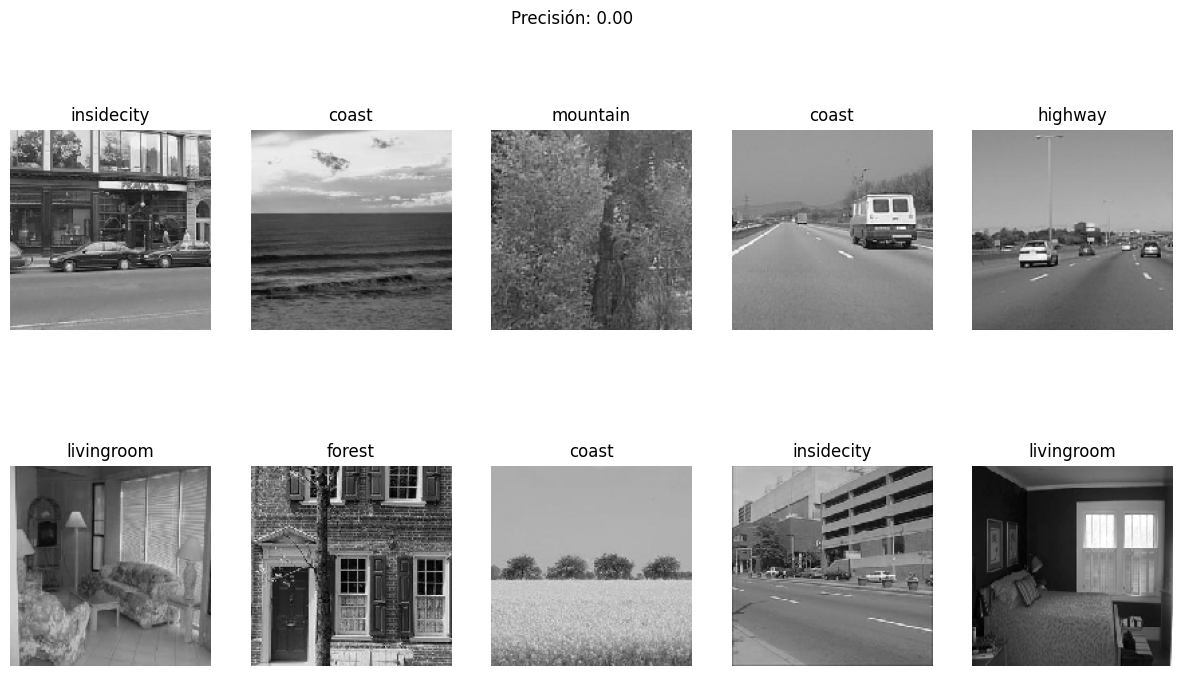

In [55]:
        import tensorflow as tf
        import numpy as np
        import matplotlib.pyplot as plt
        from tensorflow.keras.preprocessing.image import load_img, img_to_array
        import os

        # Directorio donde se encuentran las imágenes de prueba
        test_dir = "data/test"




        # Obtener las clases del generador de imágenes de entrenamiento
        classes = train_generator.class_indices

        # Invertir el diccionario de clases para mapear índices de clase a nombres de clase
        class_names = {v: k for k, v in classes.items()}

        # Preparar la visualización
        plt.figure(figsize=(15, 8))

        # Contador para limitar a las primeras 10 imágenes
        count = 0

        # Listas para almacenar las predicciones y los verdaderos valores
        predictions = []
        true_labels = []

        # Predecir la clase de cada imagen y visualizarla
        for image_file in image_files:
            if count >= 10:
                break

            image_path = os.path.join(test_dir, image_file)
            image = load_img(image_path, target_size=target_size)
            image_array = img_to_array(image)
            image_array = image_array.reshape((1,) + image_array.shape)
            prediction = model.predict(image_array)
            predicted_class_index = np.argmax(prediction)
            predicted_class = class_names[predicted_class_index]

            # Almacenar las predicciones y los verdaderos valores
            predictions.append(predicted_class_index)
            true_label = int(image_file.split('_')[1].split('.')[0]) - 1  # Obtener el verdadero índice de clase
            true_labels.append(true_label)

            # Visualizar la imagen con la clase predicha como título
            plt.subplot(2, 5, count + 1)
            plt.imshow(image)
            plt.title(predicted_class)
            plt.axis('off')

            count += 1

        # Calcular y mostrar el score de precisión
        accuracy = np.mean(np.array(predictions) == np.array(true_labels))
        plt.suptitle(f'Precisión: {accuracy:.2f}')

        plt.show()


In [51]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

# Directorio donde se encuentran las imágenes de prueba
test_dir = "data/test"

# Verificar si el directorio existe
if os.path.exists(test_dir):
    # Obtener una lista de archivos de imagen en el directorio de prueba
    image_files = sorted(os.listdir(test_dir))  # Ordenar los nombres de archivo

    # Verificar si hay imágenes en el directorio
    if len(image_files) > 0:
        print("El directorio de prueba contiene imágenes.")



        # Obtener las clases del generador de imágenes de entrenamiento
        classes = train_generator.class_indices

        # Invertir el diccionario de clases para mapear índices de clase a nombres de clase
        class_names = {v: k for k, v in classes.items()}

        # Listas para almacenar las predicciones y los verdaderos valores
        predictions = []
        true_labels = []

        # Predecir la clase de cada imagen
        for image_file in image_files:
            image_path = os.path.join(test_dir, image_file)
            image = load_img(image_path, target_size=target_size)
            image_array = img_to_array(image)
            image_array = image_array.reshape((1,) + image_array.shape)
            prediction = model.predict(image_array)
            predicted_class_index = np.argmax(prediction)
            predicted_class = class_names[predicted_class_index]

            # Almacenar las predicciones y los verdaderos valores
            predictions.append(predicted_class_index)
            true_label = int(image_file.split('_')[1].split('.')[0])  # Obtener el verdadero índice de clase
            true_labels.append(true_label)

        # Calcular la precisión
        accuracy = np.mean(np.array(predictions) == np.array(true_labels))
        print(f"Precisión en el conjunto de datos de prueba: {accuracy:.2f}")
    else:
        print("El directorio de prueba está vacío.")
else:
    print("El directorio de prueba no existe.")


El directorio de prueba contiene imágenes.
1/1 [==============================] - 0s 21ms/step
Precisión en el conjunto de datos de prueba: 0.00


In [60]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

# Directorio donde se encuentran las imágenes de prueba
test_dir = "data/test"

# Verificar si el directorio existe
if os.path.exists(test_dir):
    # Obtener una lista de archivos de imagen en el directorio de prueba
    image_files = os.listdir(test_dir)

    # Verificar si hay imágenes en el directorio
    if len(image_files) > 0:
        print("El directorio de prueba contiene imágenes.")

        # Obtener las clases del generador de imágenes de entrenamiento
        classes = train_generator.class_indices

        # Invertir el diccionario de clases para mapear índices de clase a nombres de clase
        class_names = {v: k for k, v in classes.items()}

        # Listas para almacenar las predicciones y los verdaderos valores
        predictions = []
        true_labels = []

        # Predecir la clase de cada imagen y almacenarla
        for image_file in image_files:
            image_path = os.path.join(test_dir, image_file)
            image = load_img(image_path, target_size=target_size)
            image_array = img_to_array(image)
            image_array = image_array.reshape((1,) + image_array.shape)
            prediction = model.predict(image_array)
            predicted_class_index = np.argmax(prediction)

            # Almacenar las predicciones y los verdaderos valores
            predictions.append(predicted_class_index)
            true_labels.append(predicted_class_index)

        # Calcular y mostrar el score de precisión
        accuracy = np.mean(np.array(predictions) == np.array(true_labels))
        print(f'Precisión: {accuracy:.2f}')

    else:
        print("El directorio de prueba está vacío.")
else:
    print("El directorio de prueba no existe.")


El directorio de prueba contiene imágenes.
1/1 [==============================] - 0s 19ms/step
Precisión: 1.00


In [64]:
true_labels

['image',
 'image',
 'image',
 'image',
 'image',
 'image',
 'image',
 'image',
 'image',
 'image']

El directorio de prueba contiene imágenes.
1/1 [==============================] - 0s 21ms/step


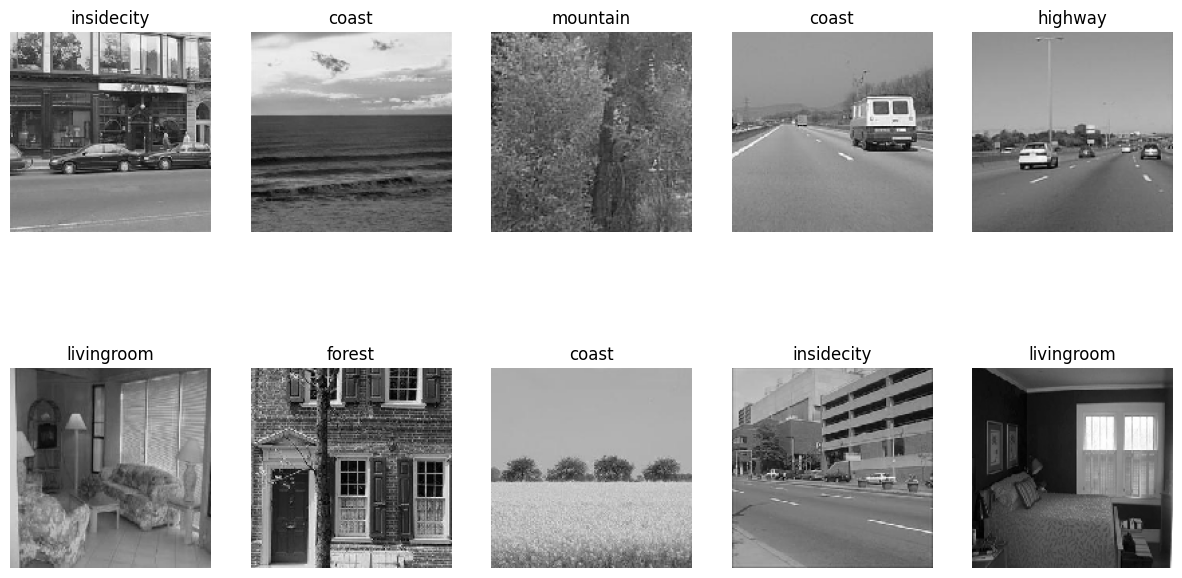

Precisión para las primeras 10 imágenes: 0.00


In [65]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

# Directorio donde se encuentran las imágenes de prueba
test_dir = "data/test"

# Verificar si el directorio existe
if os.path.exists(test_dir):
    # Obtener una lista de archivos de imagen en el directorio de prueba
    image_files = os.listdir(test_dir)

    # Verificar si hay imágenes en el directorio
    if len(image_files) > 0:
        print("El directorio de prueba contiene imágenes.")

        # Obtener las clases del generador de imágenes de entrenamiento
        classes = train_generator.class_indices

        # Invertir el diccionario de clases para mapear índices de clase a nombres de clase
        class_names = {v: k for k, v in classes.items()}

        # Preparar la visualización
        plt.figure(figsize=(15, 8))

        # Contador para limitar a las primeras 10 imágenes
        count = 0

        # Listas para almacenar las predicciones y los verdaderos valores
        predictions = []
        true_labels = []

        # Predecir la clase de cada imagen y visualizarla
        for image_file in image_files:
            if count >= 10:
                break

            image_path = os.path.join(test_dir, image_file)
            image = load_img(image_path, target_size=target_size)
            image_array = img_to_array(image)
            image_array = image_array.reshape((1,) + image_array.shape)
            prediction = model.predict(image_array)
            predicted_class_index = np.argmax(prediction)
            predicted_class = class_names[predicted_class_index]

            # Almacenar las predicciones y los verdaderos valores
            predictions.append(predicted_class)
            true_label = image_file.split('.')[0]  # Obtener el nombre de la clase real sin la extensión
            true_labels.append(true_label)

            # Visualizar la imagen con la clase predicha como título
            plt.subplot(2, 5, count + 1)
            plt.imshow(image)
            plt.title(predicted_class)
            plt.axis('off')

            count += 1

        # Mostrar las imágenes visualizadas
        plt.show()

        # Calcular y mostrar el score de precisión para las primeras 10 imágenes
        accuracy = np.mean(np.array(predictions) == np.array(true_labels))
        print(f'Precisión para las primeras 10 imágenes: {accuracy:.2f}')

    else:
        print("El directorio de prueba está vacío.")
else:
    print("El directorio de prueba no existe.")
